### Labeling New Customers Notebook

##### Importing Packages

In [50]:
import pandas as pd
import numpy as np

##### Importing Dataset

In [51]:
df= pd.read_excel('online_retail_II.xlsx', parse_dates= ['InvoiceDate'], dtype= {
    'Customer ID' : str,
    'Invoice' : str,
    'StockCode' : str
})
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


##### Exploring dataset

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  object        
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 32.1+ MB


In [53]:
df.isna().sum()     # finding columns containing null values

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [54]:
df= df.dropna(subset= 'Customer ID').reset_index(drop= True)

In [55]:
df_invoice= df.drop_duplicates(
    subset= ['Invoice'])[['Invoice', 'InvoiceDate','Customer ID']].reset_index(drop= True)
df_invoice.head()

,Invoice,InvoiceDate,Customer ID
0,489434,2009-12-01 07:45:00,13085
1,489435,2009-12-01 07:46:00,13085
2,489436,2009-12-01 09:06:00,13078
3,489437,2009-12-01 09:08:00,15362
4,489438,2009-12-01 09:24:00,18102


##### Defining the function for calculating mean interval between subsequent purchases of each customer:

In [56]:
def mean_purchase_widnow(df):
    customers = df['Customer ID'].unique()
    dff = pd.DataFrame()
    for customer in customers:
        temp_df = df[df['Customer ID'] == customer].sort_values(
            by='InvoiceDate').reset_index(drop=True)
        diff_dates = []
        for i in range(len(temp_df) - 1):
            diff = temp_df.loc[i+1, 'InvoiceDate'] - temp_df.loc[i, 'InvoiceDate']
            diff_dates.append(diff)
            mean_diff = np.mean(diff_dates)
            dff.loc[customer, 'mean_diff'] = mean_diff
    return dff

In [57]:
df_mean_interval= mean_purchase_widnow(df_invoice)
df_mean_interval.head()

,mean_diff
13085,53 days 01:18:20
13078,7 days 03:41:33.461538461
15362,290 days 01:29:00
18102,3 days 23:16:48.510638297
12682,16 days 05:27:00


##### Calculating threshold for new customer purhcase period:

40.0


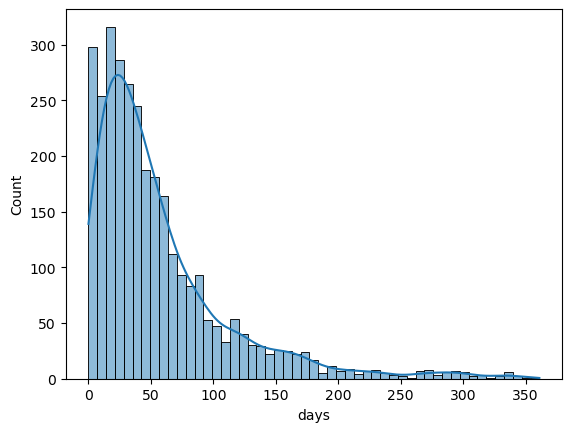

In [58]:
from operator import attrgetter
import seaborn as sns
import matplotlib.pyplot as plt
dff= df_mean_interval['mean_diff'].apply(attrgetter('days'))
sns.histplot(dff, kde= True)
plt.xlabel('days')
print(dff.median())

##### Creating a dataframe containing each customer's recency and frequency values:

In [59]:
for index in range(len(df_invoice)):
    df_invoice.loc[index, 'diff_dates'] = (
    df_invoice['InvoiceDate'].max() - df_invoice.loc[index, 'InvoiceDate']).days
recency = df_invoice.groupby(['Customer ID'])['diff_dates'].min()

frequency = df_invoice.groupby('Customer ID')['Invoice'].count()

rf = pd.merge(
            left=recency,
            right=frequency,
            how='inner',
            on='Customer ID')
rf.rename(columns= {
    'diff_dates' : 'recency',
    'Invoice' : 'frequency'
}, inplace= True)
rf.head()

,recency,frequency
Customer ID,,
12346,66.0,15
12347,2.0,2
12348,73.0,1
12349,42.0,4
12351,10.0,1


##### Labeling new customers:

In [60]:
index= rf[(rf['recency'] <= 40) & (rf['frequency'] == 1)].index     #creating a list of indixes that pass our two conditions simultaneously
rf.loc[index, "is_newCustomer"]= True
rf['is_newCustomer'].fillna(False, inplace= True)
rf.head()

,recency,frequency,is_newCustomer
Customer ID,,,
12346,66.0,15,False
12347,2.0,2,False
12348,73.0,1,False
12349,42.0,4,False
12351,10.0,1,True
